In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
            
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
         # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
           
        ) # output_size = 9
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
       #) # output_size = 7

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.pool1(x)
        #x = self.dropout(x)
        
        x = self.convblock4(x)
       
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        
        #x = self.dropout(x)
        x = self.gap(x) 
        x = self.convblock7(x)
        #x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # calculate Loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13089242577552795 Batch_id=468 Accuracy=91.77: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.018061915412545204 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.04274347051978111 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.02190392278134823 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 38.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.07168552279472351 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:12<00:00, 44.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.03818255662918091 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 38.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.04074004292488098 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 39.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.05091099068522453 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.05549286678433418 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.03421633318066597 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.04629450663924217 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.005513310432434082 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.02527151070535183 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.01593671180307865 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.1168757975101471 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.06696601957082748 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.045317620038986206 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.0065878829918801785 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 18


Loss=0.028183504939079285 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.019803935661911964 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.004815469030290842 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.005795458797365427 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.040451113134622574 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 39.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.0038852293509989977 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 38.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.017423182725906372 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 25


Loss=0.024433011189103127 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 39.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.006728956941515207 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.010776355862617493 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.021391073241829872 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.0513966828584671 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 30


Loss=0.02670123428106308 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 38.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.0519583486020565 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 38.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.029171690344810486 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 33


Loss=0.030587710440158844 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 46.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.1327728033065796 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.0029333780985325575 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.022146696224808693 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

EPOCH: 37


Loss=0.003686199663206935 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:11<00:00, 39.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 38


Loss=0.0010800162563100457 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 44.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.03845003619790077 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]



Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

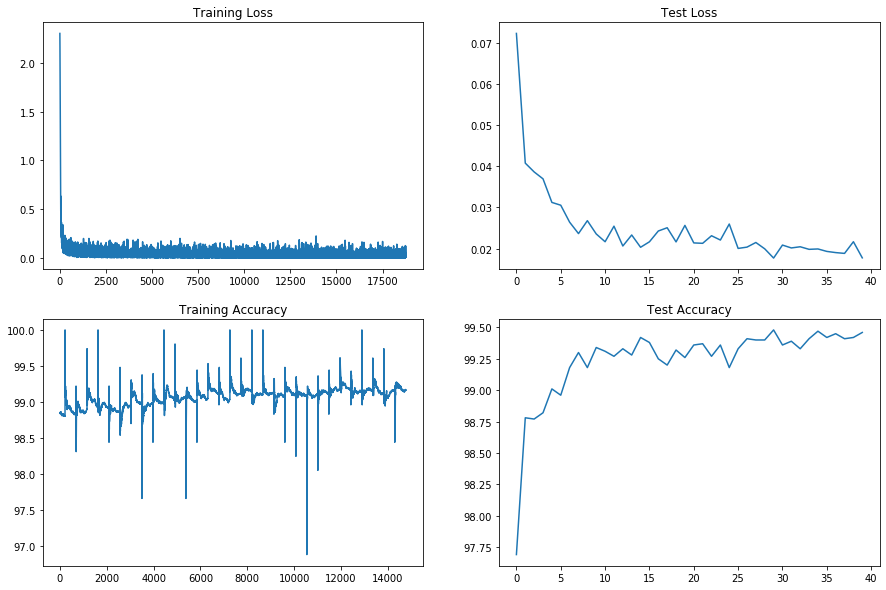

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Submitted by G Uday Kiran and V Srilakshmi